In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import tensorflow as tf
import IPython
import IPython.display
import matplotlib as mpl
import seaborn as sns
from matplotlib.patches import Patch
mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False
path = "/Users/eliassovikgunnarsson/Downloads/vix-daily_csv.csv"
df = pd.read_csv(path, header = 0, index_col= 0)
df.head()

,VIX Open,VIX High,VIX Low,VIX Close
Date,,,,
2004-01-02,17.96,18.68,17.54,18.22
2004-01-05,18.45,18.49,17.44,17.49
2004-01-06,17.66,17.67,16.19,16.73
2004-01-07,16.72,16.75,15.50,15.50
2004-01-08,15.42,15.68,15.32,15.61


<AxesSubplot: xlabel='Date'>

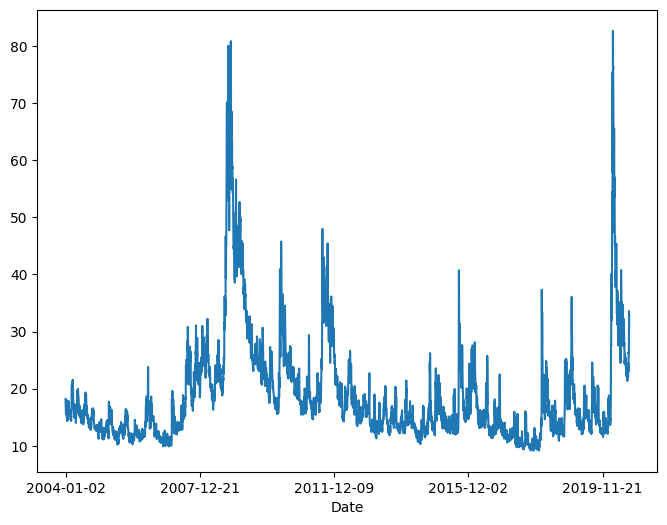

In [2]:
df['VIX Close'].plot()

#### References
* [How To Backtest Machine Learning Models for Time Series Forecasting](https://machinelearningmastery.com/backtest-machine-learning-models-time-series-forecasting/)
* [Omphalos, Uber’s Parallel and Language-Extensible Time Series Backtesting Tool](https://www.uber.com/en-NO/blog/omphalos/)
* [Walk-Forward Analysis Demonstration with backtrader](https://ntguardian.wordpress.com/2017/06/19/walk-forward-analysis-demonstration-backtrader/)

In applied machine learning, we often split our data into a train and test set: the training set used to prepare the model and the test set used to evaluate it. We may evven use k-fold cross validation that repeats this process by systematically splitting the data into k groups, each given a chance to be a held out model. **These models cannot be directly udes twith time series data.** This is because they assume that there is no relationship between the observations, that each observation is independent.

### Walk Forward Validation
In practice, we very likely will retrain our model as new data becomes available. This would give the model the best opportunity to make good forecasts at each time steps. We can evaluate our machine learning models under this assumption. This procedure applies two types of backtesting: sliding window and expanding window. While both have their applicable use cases, the sliding window work achieves favorable balance between model accuracy and training time [especially when it comes to testing high frequency data such as daily and hourly time series.](https://www.uber.com/en-NO/blog/omphalos/) The expanding wondow form, on the other hand is used more often in weekly, monthly or quarterly time series where the number of historical pointa are limited.

##### Sliding window
The sliding window method requires three hyperparameters: training window size, forecasting window size (horizon), and sliding steps:
* Training window size: The number of data points included in a training pass
* Forecasting window size: the number of data points to include in forecasting
* Sliding steps: the number of data points skipped from one pass to another

![image info](images/sliding_window.png)

The build in TimeSeriesSplit from sklearn.model_selection is limited to an expanding window

In [3]:
from sklearn.model_selection import TimeSeriesSplit
X = df['VIX Close']
cv = TimeSeriesSplit(n_splits=5, gap=200)

[Visualizing cross-validation behavior](https://scikit-learn.org/stable/auto_examples/model_selection/plot_cv_indices.html)

In [4]:
import tscv_sliding
rng = np.random.RandomState(1338)
cmap_data = plt.cm.Paired
cmap_cv = plt.cm.coolwarm
n_splits = 5

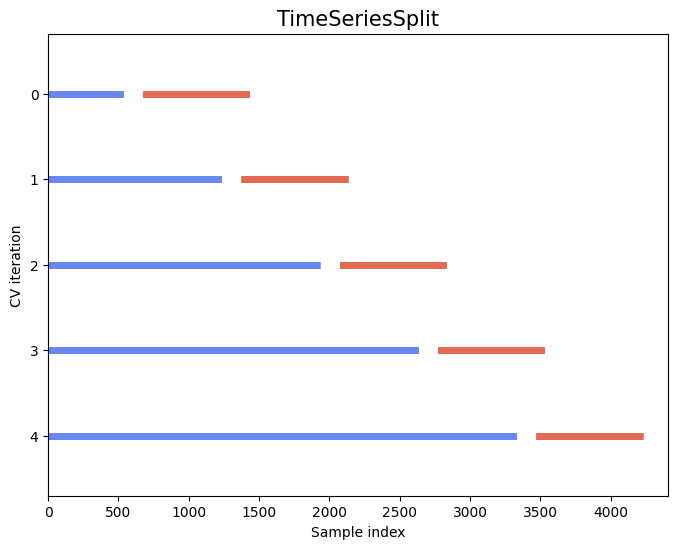

In [5]:
fig, ax = plt.subplots()
tscv_sliding.plot_cv_indices(cv, X, ax, n_splits)
plt.show()

The build in TimeSeriesSplit class from sklearn.model_selection can be modified to a sliding window

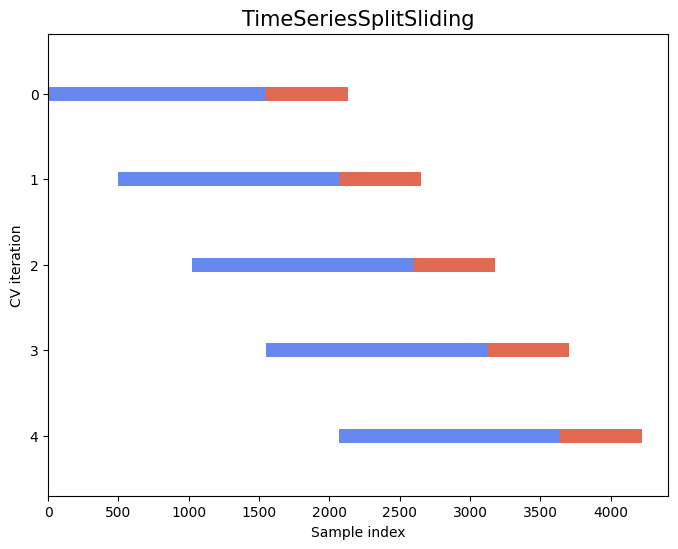

In [6]:
tscv = tscv_sliding.TimeSeriesSplitSliding(n_splits=n_splits, train_splits=3, test_splits = 1, fixed_length=True)
fig, ax = plt.subplots()
tscv_sliding.plot_cv_indices(tscv, X, ax)
plt.show()

### Data Windowing

In [7]:
from window_generator import WindowGenerator
df.columns

Index(['VIX Open', 'VIX High', 'VIX Low', 'VIX Close'], dtype='object')

In [8]:
df = df.drop(['VIX Open', 'VIX High', 'VIX Low'], axis = 1)
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]
df.head()

,VIX Close
Date,
2004-01-02,18.22
2004-01-05,17.49
2004-01-06,16.73
2004-01-07,15.50
2004-01-08,15.61


In [9]:
w1 = WindowGenerator(input_width=30, label_width=1, shift=1, label_columns=['VIX Close'], train_df=train_df, val_df=val_df, test_df=test_df)
w1

Total window size: 31
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
Label indices: [30]
Label column name(s): ['VIX Close']

In [10]:
# Stack three slices, the length of the total window.
example_window = tf.stack([np.array(df[:w1.total_window_size]),
                           np.array(df[100:100+w1.total_window_size]),
                           np.array(df[200:200+w1.total_window_size])])

example_inputs, example_labels = w1.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

All shapes are: (batch, time, features)
Window shape: (3, 31, 1)
Inputs shape: (3, 30, 1)
Labels shape: (3, 1, 1)


2023-03-06 12:52:13.135772: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-03-06 12:52:13.135925: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [11]:
samples = w1.make_dataset(df)
samples.element_spec

(TensorSpec(shape=(None, 30, 1), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

In [12]:
for example_inputs, example_labels in w1.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 30, 1)
Labels shape (batch, time, features): (32, 1, 1)


2023-03-06 12:52:13.375526: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


In [13]:
MAX_EPOCHS = 200


def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [23]:
folds = w1.folds
folds.shape

(5, 2)

In [15]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(10, return_sequences=True),
    tf.keras.layers.LSTM(10, return_sequences=False),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(lstm_model, w1)

val_performance = {}
performance = {}

val_performance['LSTM'] = lstm_model.evaluate(w1.val)
performance['LSTM'] = lstm_model.evaluate(w1.test, verbose=0)

Epoch 1/200


2023-03-06 12:52:15.263396: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-03-06 12:52:15.534628: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-03-06 12:52:15.662356: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-03-06 12:52:15.800833: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-03-06 12:52:15.992588: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


91/91 [==============================] - ETA: 0s - loss: 422.6842 - mean_absolute_error: 18.1797

2023-03-06 12:52:18.885336: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-03-06 12:52:18.989158: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-03-06 12:52:19.048576: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


91/91 [==============================] - 6s 37ms/step - loss: 422.6842 - mean_absolute_error: 18.1797 - val_loss: 157.2349 - val_mean_absolute_error: 11.7104
Epoch 2/200
91/91 [==============================] - 2s 25ms/step - loss: 318.8535 - mean_absolute_error: 15.0606 - val_loss: 102.4433 - val_mean_absolute_error: 9.0812
Epoch 3/200
91/91 [==============================] - 2s 26ms/step - loss: 261.1193 - mean_absolute_error: 13.0594 - val_loss: 78.6099 - val_mean_absolute_error: 7.6588
Epoch 4/200
91/91 [==============================] - 2s 25ms/step - loss: 230.3181 - mean_absolute_error: 11.8390 - val_loss: 63.3712 - val_mean_absolute_error: 6.5884
Epoch 5/200
91/91 [==============================] - 2s 25ms/step - loss: 207.4223 - mean_absolute_error: 10.8305 - val_loss: 51.6374 - val_mean_absolute_error: 5.6275
Epoch 6/200
91/91 [==============================] - 3s 27ms/step - loss: 188.2466 - mean_absolute_error: 9.9060 - val_loss: 42.4047 - val_mean_absolute_error: 4.7794
Ep

In [16]:
lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 10)            480       
                                                                 
 lstm_1 (LSTM)               (None, 10)                840       
                                                                 
 dense (Dense)               (None, 1)                 11        
                                                                 
Total params: 1,331
Trainable params: 1,331
Non-trainable params: 0
_________________________________________________________________


In [17]:
lstm_model_wide = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(100, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(lstm_model_wide, w1)

val_performance['LSTM_WIDE'] = lstm_model_wide.evaluate(w1.val)
performance['LSTM_WIDE'] = lstm_model_wide.evaluate(w1.test, verbose=0)

Epoch 1/200


2023-03-06 12:52:54.125738: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-03-06 12:52:54.293404: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 3/91 [..............................] - ETA: 2s - loss: 370.9999 - mean_absolute_error: 18.0838  

2023-03-06 12:52:54.429114: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


91/91 [==============================] - ETA: 0s - loss: 216.4584 - mean_absolute_error: 10.6232

2023-03-06 12:52:56.221293: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-03-06 12:52:56.295000: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


91/91 [==============================] - 3s 23ms/step - loss: 216.4584 - mean_absolute_error: 10.6232 - val_loss: 29.0853 - val_mean_absolute_error: 4.5619
Epoch 2/200
91/91 [==============================] - 2s 23ms/step - loss: 95.4982 - mean_absolute_error: 6.3758 - val_loss: 27.9167 - val_mean_absolute_error: 4.6147
Epoch 3/200
91/91 [==============================] - 2s 21ms/step - loss: 73.1656 - mean_absolute_error: 5.1080 - val_loss: 17.7074 - val_mean_absolute_error: 3.4747
Epoch 4/200
91/91 [==============================] - 2s 19ms/step - loss: 53.9334 - mean_absolute_error: 4.0047 - val_loss: 16.6117 - val_mean_absolute_error: 2.8543
Epoch 5/200
91/91 [==============================] - 2s 21ms/step - loss: 43.9672 - mean_absolute_error: 3.6106 - val_loss: 16.9571 - val_mean_absolute_error: 3.0610
Epoch 6/200
91/91 [==============================] - 2s 17ms/step - loss: 37.8233 - mean_absolute_error: 3.3822 - val_loss: 15.1824 - val_mean_absolute_error: 2.6704
Epoch 7/200
91

In [18]:
#predictions
#predictions = predictions[:,-1]

In [19]:
predicted = predictions.flatten()
actual = y.flatten()

timesteps = np.array([i for  i in range(len(predicted))])

n = 200

fig, ax = plt.subplots(figsize=(20,10))
ax.plot(timesteps[n:50+n], predicted[n:50+n], label = 'Predicted')
ax.plot(timesteps[n:50+n], actual[n:50+n], label = 'actual')
ax.legend()
plt.show()

NameError: name 'predictions' is not defined

In [ ]:
lstm_model.summary()

Model: "sequential_52"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_73 (LSTM)              (None, 30, 10)            480       
                                                                 
 lstm_74 (LSTM)              (None, 10)                840       
                                                                 
 dense_52 (Dense)            (None, 1)                 11        
                                                                 
Total params: 1,331
Trainable params: 1,331
Non-trainable params: 0
_________________________________________________________________


InvalidArgumentError: Index out of range using input dim 2; input has only 2 dims [Op:StridedSlice] name: strided_slice/

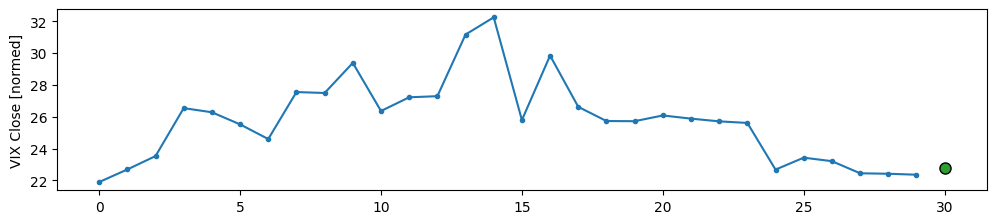

In [ ]:
w1.plot(lstm_model)

In [ ]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i: (i + time_steps)].to_numpy()
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [ ]:
TIME_STEPS = 30

X, y = create_dataset(X = df.drop('VIX Close', axis = 1), y = df['VIX Close'], time_steps=TIME_STEPS)